<a href="https://colab.research.google.com/github/Kcnarf/spamDetectionWithML/blob/master/SpamDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving spamham_vsc_training.csv to spamham_vsc_training.csv


In [ ]:
import io

# data = pd.read_csv('SMSSpamCollection.csv',encoding = 'utf8', sep='\t', header=None, names=["v1", "v2"])
data = pd.read_csv('spamham_vsc_training.csv',encoding = 'utf8', sep=';', header=None, names=["spam", "text"])

data.head()

,spam,text
0,Spam,"Hi customercare@help.affiny.co.uk, We will he..."
1,Spam,96 ...
2,Spam,My phone says that you are 3 km away. I'm Wid...
3,Spam,"Elizbeth Smith, Thank you for contacting us. ..."
4,Spam,96 ...


# Splitting data

In [ ]:
from sklearn.model_selection import train_test_split

emails_train, emails_test, target_train, target_test = train_test_split(data.text,data.spam,test_size = 0.2)
data.info

<bound method DataFrame.info of       spam                                               text
0     Spam  Hi customercare@help.affiny.co.uk,  We will he...
1     Spam  96                                            ...
2     Spam  My phone says that you are 3 km away.  I'm Wid...
3     Spam  Elizbeth Smith,  Thank you for contacting us. ...
4     Spam  96                                            ...
...    ...                                                ...
1660   Ham  Hello I need to cancel my account but when I t...
1661   Ham  Please can you stop automatic renewal because ...
1662   Ham             cancel my profile i will not come back
1663   Ham  Please cancel my automatic subscription. It se...
1664   Ham  Cancel my Automatic renewal and confirm by email 

[1665 rows x 2 columns]>

In [ ]:
emails_train.shape

(1332,)

# Preprocessing

In [ ]:
def remove_hyperlink(word):
    return  re.sub(r"http\S+", "", word)

def to_lower(word):
    result = word.lower()
    return result

def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

def remove_whitespace(word):
    result = word.strip()
    return result

def replace_newline(word):
    return word.replace('\n','')



def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

x_train = [clean_up_pipeline(o) for o in emails_train]
x_test = [clean_up_pipeline(o) for o in emails_test]

x_train[0]

'i asked earlier regarding not being able to purchase connect i have tried the app chrome internet explorer and still cannot purchase i even deleted and re installed the app but nothing the other upgrades work but not that one'

#Label encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_y = le.fit_transform(target_train.values)
test_y = le.transform(target_test.values)

In [ ]:
train_y

array([0, 1, 0, ..., 1, 1, 0])

# Text Tokenization

In [ ]:
## some config values 
embed_size = 100 # how big is each word vector
max_feature = 50000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 2000 # max number of words in a question to use

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=max_feature)

tokenizer.fit_on_texts(x_train)

x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

x_train_features[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


[7,
 465,
 963,
 603,
 17,
 290,
 259,
 1,
 525,
 466,
 7,
 25,
 277,
 3,
 321,
 1373,
 1374,
 2417,
 5,
 220,
 299,
 525,
 7,
 361,
 362,
 5,
 701,
 2418,
 3,
 321,
 104,
 702,
 3,
 337,
 1702,
 150,
 104,
 17,
 34,
 97]

# Padding
Same length for all tokenized sequences

In [ ]:
from keras.preprocessing.sequence import pad_sequences
x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)
x_train_features[0]

array([ 0,  0,  0, ..., 17, 34, 97], dtype=int32)

# Model

In [ ]:
import tensorflow as tf

# were you lucky today?
!nvidia-smi -L

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

tf.device('/device:GPU:0')

GPU 0: Tesla K80 (UUID: GPU-510222e6-cd8a-0d8a-b1c4-f661d6ef4e0d)
Found GPU at: /device:GPU:0


In [ ]:
# create the model
from keras.layers import Bidirectional, Dense, Input, LSTM, Embedding, Dropout, Activation

embedding_vecor_length = 32

model = tf.keras.Sequential()
model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 32)          1600000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               49664     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 1,651,745
Trainable params: 1,651,745
Non-trainable params: 0
_________________________________________________________________
None


# Training

Epoch 1/20
6/6 [==============================] - 8s 712ms/step - loss: 0.6885 - accuracy: 0.5803 - val_loss: 0.6765 - val_accuracy: 0.5736
Epoch 2/20
6/6 [==============================] - 3s 546ms/step - loss: 0.6698 - accuracy: 0.5661 - val_loss: 0.6468 - val_accuracy: 0.5736
Epoch 3/20
6/6 [==============================] - 3s 542ms/step - loss: 0.6239 - accuracy: 0.5698 - val_loss: 0.6729 - val_accuracy: 0.5946
Epoch 4/20
6/6 [==============================] - 3s 544ms/step - loss: 0.5557 - accuracy: 0.8056 - val_loss: 0.5185 - val_accuracy: 0.9039
Epoch 5/20
6/6 [==============================] - 3s 543ms/step - loss: 0.4761 - accuracy: 0.8994 - val_loss: 0.3914 - val_accuracy: 0.9039
Epoch 6/20
6/6 [==============================] - 3s 543ms/step - loss: 0.3447 - accuracy: 0.8874 - val_loss: 0.2646 - val_accuracy: 0.9099
Epoch 7/20
6/6 [==============================] - 3s 539ms/step - loss: 0.2213 - accuracy: 0.9610 - val_loss: 0.1783 - val_accuracy: 0.9219
Epoch 8/20
6/6 [====

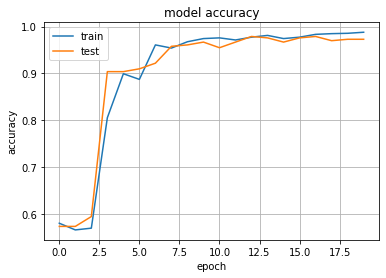

In [ ]:
history = model.fit(x_train_features, train_y, batch_size=256, epochs=20, validation_data=(x_test_features, test_y))

from  matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

#Evaluation

Precision: 98.54%
Recall: 95.07%
F1 Score: 96.77%


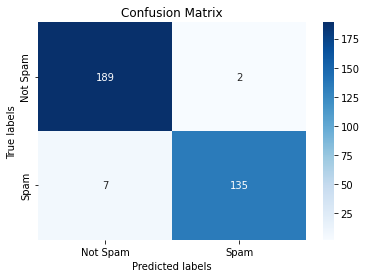

In [ ]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
import seaborn as sns
import matplotlib.pyplot as plt

y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

cf_matrix =confusion_matrix(test_y,y_predict)

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt=''); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);